## Read and Preprocessing

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import *
from imblearn.under_sampling import RandomUnderSampler
from scipy import stats


from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier


columns = ['Temperature', 'RH', 'Ws','Rain',]
data = pd.read_csv("Algerian_forest_fires_dataset_UPDATE.csv", sep='\s*,\s*',skipinitialspace=True, usecols=(columns + ['Classes']), skiprows=[0,124,125,126], engine='python')
data['Classes'] = data['Classes'].replace(['not fire', 'fire'], [0, 1])
data = data.dropna()
data = data.astype('float')
data['Classes'] = data['Classes'].astype('int')
data.head()

,Temperature,RH,Ws,Rain,Classes
0,29.0,57.0,18.0,0.0,0
1,29.0,61.0,13.0,1.3,0
2,26.0,82.0,22.0,13.1,0
3,25.0,89.0,13.0,2.5,0
4,27.0,77.0,16.0,0.0,0


In [2]:
# Dataset sampling for faster computation
pos_idx = list(data[data['Classes']==1].index)
neg_idx = list(data[data['Classes']==0].index)

data = data.loc[pos_idx+neg_idx]
print(data.shape)
data['Classes'].value_counts()

(243, 5)


Classes
1    137
0    106
Name: count, dtype: int64

In [3]:
# Train Test Split
y = data['Classes']
X = data.drop('Classes', axis=1)

undersample = RandomUnderSampler(sampling_strategy='majority')
X, y = undersample.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
print(X_train.shape)
print(X_test.shape)

(159, 4)
(53, 4)


In [4]:
y.value_counts()

Classes
0    106
1    106
Name: count, dtype: int64

## Grid Search CV


### Decision Tree Classifier

In [21]:
%%time
dtc = DecisionTreeClassifier()

parameter_grid = {'max_depth': [1,2,3,4,5,6,7],
                  'max_features': [1,2,3,4,5,6]}

cross_validation = StratifiedKFold(n_splits=10)

grid_search = GridSearchCV(dtc, param_grid=parameter_grid, cv=cross_validation)

grid_search.fit(X, y)

print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.8114718614718613
Best parameters: {'max_depth': 3, 'max_features': 3}
CPU times: total: 1.16 s
Wall time: 1.13 s


Text(50.722222222222214, 0.5, 'max_depth')

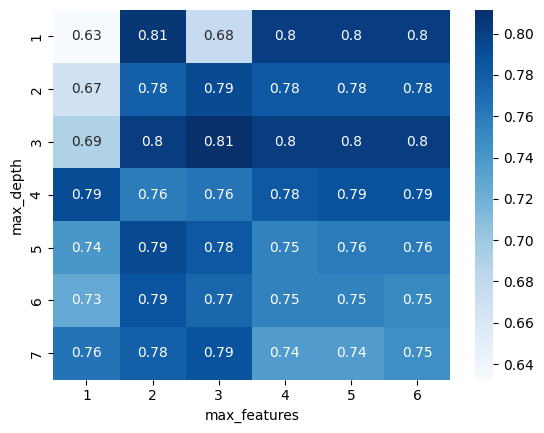

In [23]:
grid_visualization = grid_search.cv_results_['mean_test_score']
grid_visualization.shape = (7, 6)
sns.heatmap(grid_visualization, cmap='Blues', annot=True)
plt.xticks(np.arange(6) + 0.5, grid_search.param_grid['max_features'])
plt.yticks(np.arange(7) + 0.5, grid_search.param_grid['max_depth'])
plt.xlabel('max_features')
plt.ylabel('max_depth')

### Logistic Regression

In [27]:
%%time
lr = LogisticRegression(max_iter = 1000)

parameter_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
                  'solver': ['newton-cg', 'lbfgs', 'liblinear']}

cross_validation = StratifiedKFold(n_splits=10)

grid_search = GridSearchCV(lr, param_grid=parameter_grid, cv=cross_validation)

grid_search.fit(X, y)

print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.8259740259740258
Best parameters: {'C': 100, 'solver': 'liblinear'}
CPU times: total: 1.02 s
Wall time: 1.02 s


Text(50.722222222222214, 0.5, 'solver')

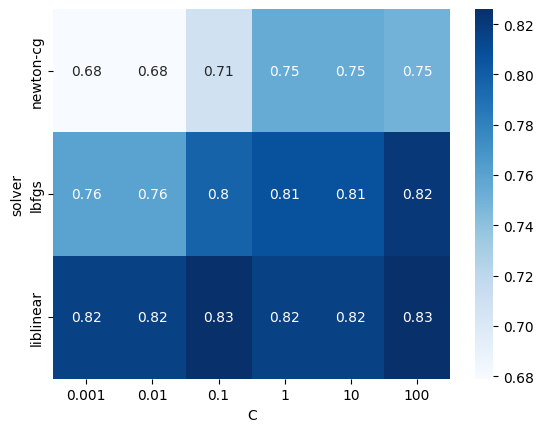

In [28]:
grid_visualization = grid_search.cv_results_['mean_test_score']
grid_visualization.shape = (3, 6)
sns.heatmap(grid_visualization, cmap='Blues', annot=True)
plt.xticks(np.arange(6) + 0.5, grid_search.param_grid['C'])
plt.yticks(np.arange(3) + 0.5, grid_search.param_grid['solver'])
plt.xlabel('C')
plt.ylabel('solver')

### Random Forest Classifier

In [30]:
%%time
rfc = RandomForestClassifier()

parameter_grid = {'n_estimators' : [5, 10, 50, 100],
                    'max_depth' : [2, 3, 5, 10],
                    'class_weight' : [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]}

cross_validation = StratifiedKFold(n_splits=10)

grid_search = GridSearchCV(rfc,
                           param_grid=parameter_grid,
                           cv=cross_validation,
                           n_jobs=-1)

grid_search.fit(X, y)

print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.8731601731601731
Best parameters: {'class_weight': None, 'max_depth': 2, 'n_estimators': 5}
CPU times: total: 609 ms
Wall time: 6.65 s


### SVC

In [34]:
%%time
svc = SVC(probability=True)

parameter_grid = {'C': [0.1, 1, 10, 100],
                  'gamma': [1, 0.1, 0.01, 0.001],
                  'kernel': ['rbf', 'sigmoid']} #poly not working?

cross_validation = StratifiedKFold(n_splits=10)

grid_search = GridSearchCV(svc,
                           param_grid=parameter_grid,
                           cv=cross_validation,
                           n_jobs=-1)

grid_search.fit(X, y)

print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.7876623376623377
Best parameters: {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
CPU times: total: 203 ms
Wall time: 718 ms


### Gradient Boosting Classifier

In [39]:
%%time
xbg = GradientBoostingClassifier()

parameter_grid = {"learning_rate": [0.01, 0.05, 0.1, 0.15, 0.2],
    "min_samples_split": np.linspace(0.1, 0.5, 12),
    "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "criterion": ['squared_error', 'friedman_mse'],
    "subsample":[0.5, 0.8, 0.9, 1.0],
    "n_estimators":[10]}

cross_validation = StratifiedKFold(n_splits=10)

grid_search = GridSearchCV(xbg,
                           param_grid=parameter_grid,
                           cv=cross_validation,
                           n_jobs=-1)

grid_search.fit(X, y)

print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.882034632034632
Best parameters: {'criterion': 'friedman_mse', 'learning_rate': 0.1, 'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 0.13636363636363638, 'min_samples_split': 0.1, 'n_estimators': 10, 'subsample': 0.5}
CPU times: total: 2min 8s
Wall time: 9min 34s


### Naive Bayes

In [40]:
%%time
xbg = GaussianNB()

parameter_grid = {'var_smoothing': np.logspace(0,-9, num=100)}

cross_validation = StratifiedKFold(n_splits=10)

grid_search = GridSearchCV(xbg,
                           param_grid=parameter_grid,
                           cv=cross_validation,
                           n_jobs=-1)

grid_search.fit(X, y)

print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.7922077922077922
Best parameters: {'var_smoothing': 2.310129700083158e-05}
CPU times: total: 359 ms
Wall time: 820 ms


### KNeighbors Classifier

In [41]:
%%time
knn = KNeighborsClassifier()
k_range = list(range(1, 35))
weight_options = ['uniform', 'distance']
leaf_size_options =   list(range(1, 20))
p_options = list(range(1, 10))
metric_options = ['minkowski', 'chebyshev']
    
parameter_grid = dict(n_neighbors=k_range, 
                      weights=weight_options,
                      leaf_size=leaf_size_options,
                      p=p_options,
                      metric=metric_options)

cross_validation = StratifiedKFold(n_splits=10)

grid_search = GridSearchCV(knn,
                           param_grid=parameter_grid,
                           cv=cross_validation,
                           n_jobs=-1)

grid_search.fit(X, y)

print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.759090909090909
Best parameters: {'leaf_size': 3, 'metric': 'chebyshev', 'n_neighbors': 26, 'p': 1, 'weights': 'uniform'}
CPU times: total: 47.1 s
Wall time: 3min 1s


## Model Build


In [79]:
dtc = DecisionTreeClassifier(max_features=3, max_depth=3)
dtc = dtc.fit(X_train, y_train)
y_dtc = dtc.predict(X_test)
conf_dtc = confusion_matrix(y_test, y_dtc)
acc_dtc = accuracy_score(y_test, y_dtc)
prec_dtc = precision_score(y_test, y_dtc)
rec_dtc = recall_score(y_test, y_dtc)
f1_dtc = f1_score(y_test, y_dtc)
print(conf_dtc)
print(acc_dtc)
print(prec_dtc)
print(rec_dtc)
print(f1_dtc)
dtc_stats = [acc_dtc, prec_dtc, rec_dtc, f1_dtc]

[[21  6]
 [ 2 24]]
0.8490566037735849
0.8
0.9230769230769231
0.8571428571428571


Text(0.5, 1.0, 'Average score: 0.807')

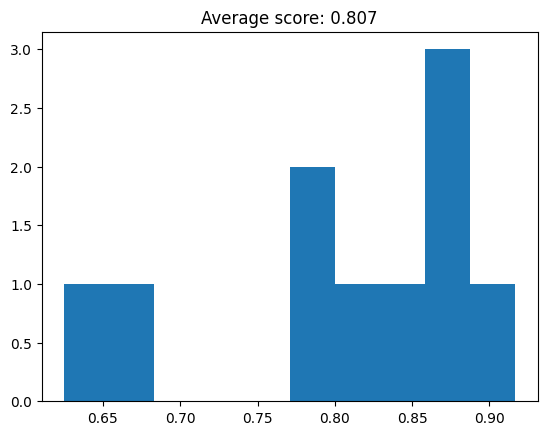

In [80]:
cv_scores = cross_val_score(dtc, X, y, cv=10)
dtc_stats.append(np.mean(cv_scores))
plt.hist(cv_scores)
plt.title('Average score: {}'.format(np.mean(cv_scores)))

In [81]:

logRegr = LogisticRegression(C=100, solver='liblinear', max_iter = 1000)
logRegr.fit(X_train, y_train)
y_logRegr = logRegr.predict(X_test)
conf_logRegr = confusion_matrix(y_test, y_logRegr)
acc_logRegr = accuracy_score(y_test, y_logRegr)
prec_logRegr = precision_score(y_test, y_logRegr)
rec_logRegr = recall_score(y_test, y_logRegr)
f1_logRegr = f1_score(y_test, y_logRegr)
print(conf_logRegr)
print(acc_logRegr)
print(prec_logRegr)
print(rec_logRegr)
print(f1_logRegr)
logRegr_stats = [acc_logRegr, prec_logRegr, rec_logRegr, f1_logRegr]

[[22  5]
 [ 5 21]]
0.8113207547169812
0.8076923076923077
0.8076923076923077
0.8076923076923077


Text(0.5, 1.0, 'Average score: 0.8233333333333335')

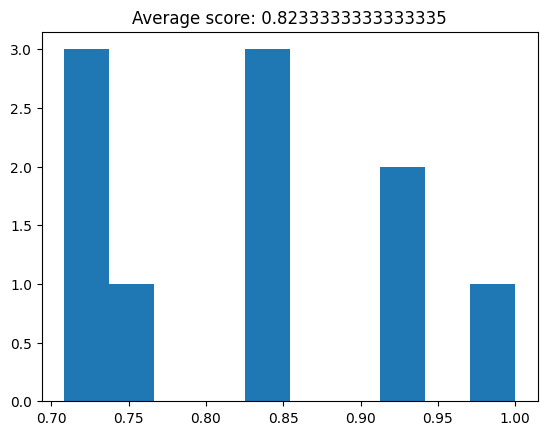

In [82]:
cv_scores = cross_val_score(logRegr, X, y, cv=10)
logRegr_stats.append(np.mean(cv_scores))
plt.hist(cv_scores)
plt.title('Average score: {}'.format(np.mean(cv_scores)))

In [83]:

rfc = RandomForestClassifier(class_weight = None, max_depth = 2, n_estimators = 5)
rfc = rfc.fit(X_train, y_train)
y_rfc = rfc.predict(X_test)
conf_rfc = confusion_matrix(y_test, y_rfc)
acc_rfc = accuracy_score(y_test, y_rfc)
prec_rfc = precision_score(y_test, y_rfc)
rec_rfc = recall_score(y_test, y_rfc)
f1_rfc = f1_score(y_test, y_rfc)
print(conf_rfc)
print(acc_rfc)
print(prec_rfc)
print(rec_rfc)
print(f1_rfc)
rfc_stats = [acc_rfc, prec_rfc, rec_rfc, f1_rfc]

[[19  8]
 [ 2 24]]
0.8113207547169812
0.75
0.9230769230769231
0.8275862068965517


Text(0.5, 1.0, 'Average score: 0.8150000000000001')

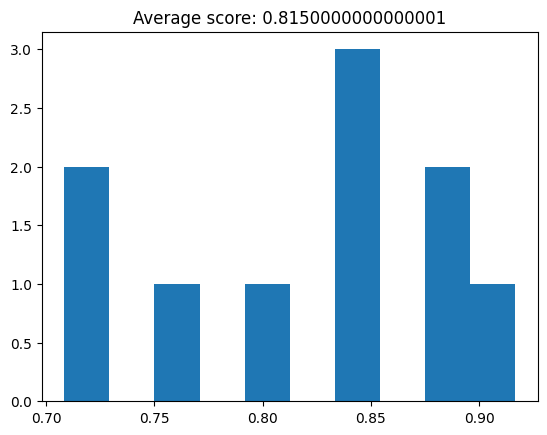

In [84]:
cv_scores = cross_val_score(rfc, X, y, cv=10)
rfc_stats.append(np.mean(cv_scores))
plt.hist(cv_scores)
plt.title('Average score: {}'.format(np.mean(cv_scores)))

In [85]:

svc = SVC(C=100, gamma=0.001, kernel='rbf')
svc = svc.fit(X_train, y_train)
y_svc = svc.predict(X_test)
conf_svc = confusion_matrix(y_test, y_svc)
acc_svc = accuracy_score(y_test, y_svc)
prec_svc = precision_score(y_test, y_svc)
rec_svc = recall_score(y_test, y_svc)
f1_svc = f1_score(y_test, y_svc)
print(conf_svc)
print(acc_svc)
print(prec_svc)
print(rec_svc)
print(f1_svc)
svc_stats = [acc_svc, prec_svc, rec_svc, f1_svc]

[[23  4]
 [ 8 18]]
0.7735849056603774
0.8181818181818182
0.6923076923076923
0.7500000000000001


Text(0.5, 1.0, 'Average score: 0.8186666666666668')

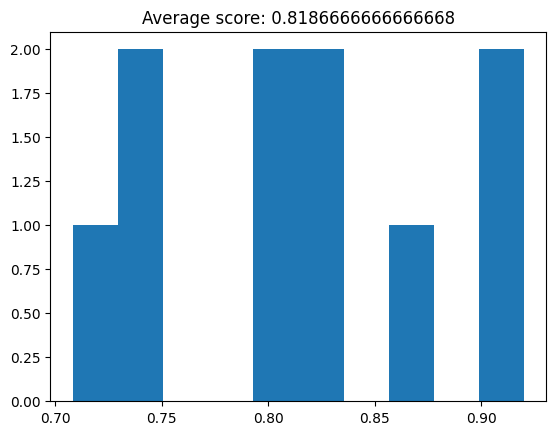

In [86]:
cv_scores = cross_val_score(svc, X, y, cv=10)
svc_stats.append(np.mean(cv_scores))
plt.hist(cv_scores)
plt.title('Average score: {}'.format(np.mean(cv_scores)))

In [87]:
xbg = GradientBoostingClassifier(criterion='friedman_mse', learning_rate=0.1, max_depth=3, max_features='log2', min_samples_leaf=0.13636363636363638, min_samples_split=0.1, n_estimators=10, subsample=0.5)
xbg.fit(X_train, y_train)
y_xbg = xbg.predict(X_test)
conf_xbg = confusion_matrix(y_test, y_xbg)
acc_xbg = accuracy_score(y_test, y_xbg)
prec_xbg = precision_score(y_test, y_xbg)
rec_xbg = recall_score(y_test, y_xbg)
f1_xbg = f1_score(y_test, y_xbg)
print(conf_xbg)
print(acc_xbg)
print(prec_xbg)
print(rec_xbg)
print(f1_xbg)
xbg_stats = [acc_xbg, prec_xbg, rec_xbg, f1_xbg]

[[22  5]
 [ 2 24]]
0.8679245283018868
0.8275862068965517
0.9230769230769231
0.8727272727272727


Text(0.5, 1.0, 'Average score: 0.8236666666666668')

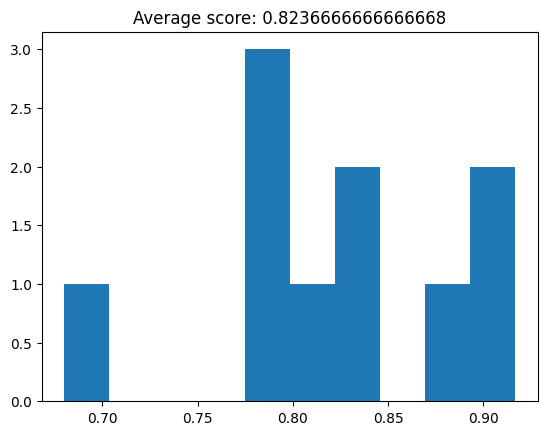

In [88]:
cv_scores = cross_val_score(xbg, X, y, cv=10)
xbg_stats.append(np.mean(cv_scores))
plt.hist(cv_scores)
plt.title('Average score: {}'.format(np.mean(cv_scores)))

In [89]:
nbayes = GaussianNB(var_smoothing=2.310129700083158e-05)
nbayes.fit(X_train, y_train)
y_nbayes = nbayes.predict(X_test)
conf_nbayes = confusion_matrix(y_test, y_nbayes)
acc_nbayes = accuracy_score(y_test, y_nbayes)
prec_nbayes = precision_score(y_test, y_nbayes)
rec_nbayes = recall_score(y_test, y_nbayes)
f1_nbayes = f1_score(y_test, y_nbayes)
print(conf_nbayes)
print(acc_nbayes)
print(prec_nbayes)
print(rec_nbayes)
print(f1_nbayes)
nbayes_stats = [acc_nbayes, prec_nbayes, rec_nbayes, f1_nbayes]

[[19  8]
 [ 2 24]]
0.8113207547169812
0.75
0.9230769230769231
0.8275862068965517


Text(0.5, 1.0, 'Average score: 0.794')

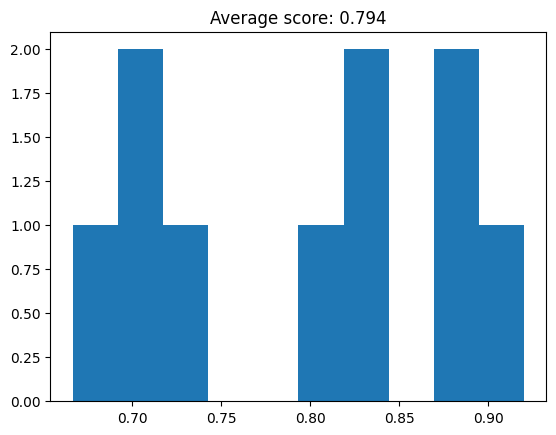

In [90]:
cv_scores = cross_val_score(nbayes, X, y, cv=10)
nbayes_stats.append(np.mean(cv_scores))
plt.hist(cv_scores)
plt.title('Average score: {}'.format(np.mean(cv_scores)))

In [91]:
knn = KNeighborsClassifier(leaf_size= 3, metric='chebyshev', n_neighbors=26, p=1, weights='uniform')
knn.fit(X_train, y_train)
y_knn = knn.predict(X_test)
conf_knn = confusion_matrix(y_test, y_knn)
acc_knn = accuracy_score(y_test, y_knn)
prec_knn = precision_score(y_test, y_knn)
rec_knn = recall_score(y_test, y_knn)
f1_knn = f1_score(y_test, y_knn)
print(conf_knn)
print(acc_knn)
print(prec_knn)
print(rec_knn)
print(f1_knn)
knn_stats = [acc_knn, prec_knn, rec_knn, f1_knn]

[[17 10]
 [ 3 23]]
0.7547169811320755
0.696969696969697
0.8846153846153846
0.7796610169491526


Text(0.5, 1.0, 'Average score: 0.7275')

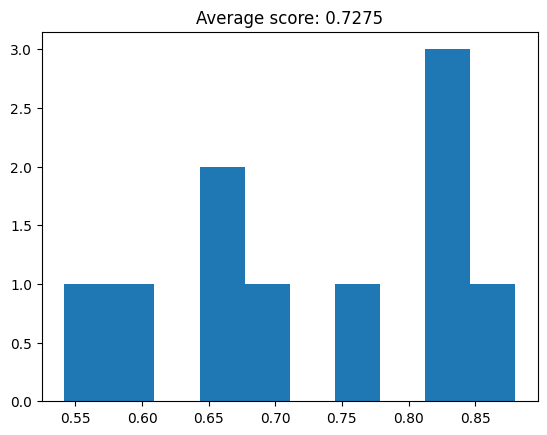

In [92]:
cv_scores = cross_val_score(knn, X, y, cv=10)
knn_stats.append(np.mean(cv_scores))
plt.hist(cv_scores)
plt.title('Average score: {}'.format(np.mean(cv_scores)))

## Comparison

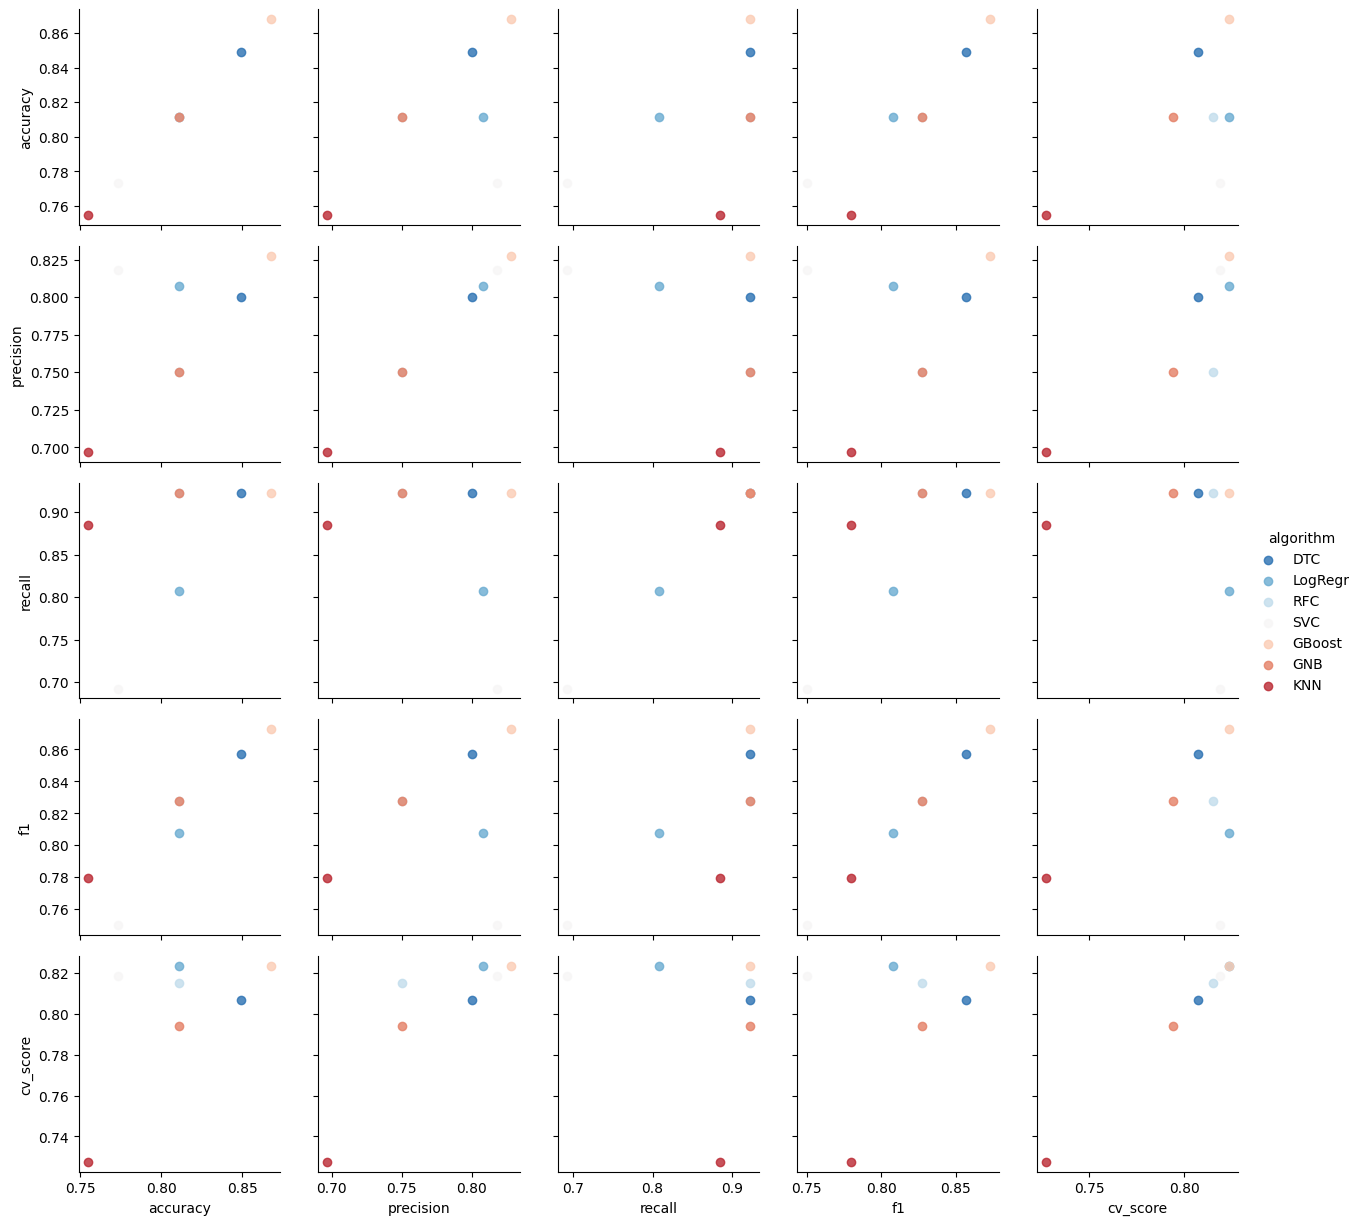

In [93]:
d = {'algorithm':['DTC', 'LogRegr', 'RFC', 'SVC', 'GBoost', 'GNB', 'KNN']}
cols = ['accuracy', 'precision', 'recall', 'f1', 'cv_score']
for i in range(0, 5):
    d[cols[i]] = [dtc_stats[i],
                   logRegr_stats[i],
                   rfc_stats[i],
                   svc_stats[i],
                   xbg_stats[i],
                   nbayes_stats[i],
                   knn_stats[i]]
comp = pd.DataFrame(data=d)
g = sns.PairGrid(comp, vars=cols,
                 hue='algorithm', palette='RdBu_r')
g.map(plt.scatter, alpha=0.8)
g.add_legend()

In [ ]:
for i in range(0, 5):
    dtc_stats[i] = round(dtc_stats[i], 3)
    logRegr_stats[i] = round(logRegr_stats[i], 3)
    rfc_stats[i] = round(rfc_stats[i], 3)
    svc_stats[i] = round(svc_stats[i], 3)
    xbg_stats[i] = round(xbg_stats[i], 3)
    nbayes_stats[i] = round(nbayes_stats[i], 3)
    knn_stats[i] = round(knn_stats[i], 3)

In [ ]:
print("\tdtc\tlogRegr\trfc\tsvc\txbg\tnbayes\tknn")
values = ["acc", "prec", "rec", "f1", "cv"]
for i in range(0, 5):
    print(values[i],dtc_stats[i], logRegr_stats[i], rfc_stats[i], svc_stats[i], xbg_stats[i], nbayes_stats[i], knn_stats[i], sep='\t')